 # Create embeddings for future analayis: this notebook will create embedding of our anndata object ad store it

In [ ]:
DSID = DatasetID
your_experiment = "raw_qc" # A string that is a key known for our desired experimnet that you wish to work on
Version = '1'

In [1]:
## Import Libraries
from __future__ import division

#single cell libraries
import scanpy as sc
import matplotlib.pyplot as plt

#general
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#plotting
import seaborn as sns
sns.set_context('talk')

In [4]:
import sys
sys.path.append("..")
import Templates.tools.DatasetDB as DB
import Templates.tools.RNA_Seq_QC as rnaqc
import Templates.tools.scProc as proc
"""
try:
    import Templates.tools.rapids_modified as rp
except ImportError:
        pass
"""

'\ntry:\n    import Templates.tools.rapids_modified as rp\nexcept ImportError:\n        pass\n'

In [5]:
import Templates.tools.rapids_modified as rp

[rank: 0] Global seed set to 0


In [6]:
%load_ext autoreload
%autoreload 2

### Check if GPU device is available 

In [7]:
GPU = rnaqc.pipeline_has_gpu()

In [8]:
GPU

True

## Instantiate a dataset object given our dataset info

In [9]:
DS = DB.DATASET(DSID, DEV, title=title, description=description, name_space=name_space, organism=organism,
                       sources=sources, tech_name=tech_name, author=author)

In [10]:
adata, adatas = DS.load_dataset(Version, your_experiment, Corr=False)

In [11]:
adata = rnaqc.load_data(adata)

In [15]:
#adata = sc.read(raw_qc)

In [16]:
adata

AnnData object with n_obs × n_vars = 361560 × 33998
    obs: 'Sample', 'Barcode', 'DemuxType_crispr', 'DemuxAssignment_crispr', 'DemuxType_hashing', 'DemuxAssignment_hashing', 'cellline', 'timepoint', 'gene_symbol', 'class', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'S_score', 'G2M_score', 'phase', 'SCN_class'
    var: 'ID', 'Symbol', 'Type'
    uns: 'DemuxAssignment_hashing_colors', 'Sample_colors', '_scvi_manager_uuid', '_scvi_uuid', 'leiden_colors', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_pca_centered', 'X_scVI', 'X_scVI_centered', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [18]:
adata.obs.head()

AnnData object with n_obs × n_vars = 361560 × 33998
    obs: 'Sample', 'Barcode', 'DemuxType_crispr', 'DemuxAssignment_crispr', 'DemuxType_hashing', 'DemuxAssignment_hashing', 'cellline', 'timepoint', 'gene_symbol', 'class', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'S_score', 'G2M_score', 'phase', 'SCN_class'
    var: 'ID', 'Symbol', 'Type'
    layers: 'counts'

In [19]:
adata.obs['gene_symbol'].value_counts().reset_index()[:10]

,index,gene_symbol
0,NTC,9304
1,CTNNB1,1506
2,TCF7L2,267
3,CD81,220
4,ADCYAP1,128
5,ST3GAL4,127
6,CACNG3,126
7,CACNA2D3,122
8,WDR48,122
9,ZNF99,121


## Subsampling CTNNB1 and TCF7L2

In [22]:
adata

AnnData object with n_obs × n_vars = 361560 × 33998
    obs: 'Sample', 'Barcode', 'DemuxType_crispr', 'DemuxAssignment_crispr', 'DemuxType_hashing', 'DemuxAssignment_hashing', 'cellline', 'timepoint', 'gene_symbol', 'class', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'S_score', 'G2M_score', 'phase', 'SCN_class'
    var: 'ID', 'Symbol', 'Type'
    layers: 'counts'

In [23]:
adata = proc.subsample_genes (adata, subsample_dic= subsample_dic, subsample_type=subsample_type)

In [24]:
adata

AnnData object with n_obs × n_vars = 360087 × 33998
    obs: 'Sample', 'Barcode', 'DemuxType_crispr', 'DemuxAssignment_crispr', 'DemuxType_hashing', 'DemuxAssignment_hashing', 'cellline', 'timepoint', 'gene_symbol', 'class', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'S_score', 'G2M_score', 'phase', 'SCN_class', 'batch'
    var: 'ID', 'Symbol', 'Type'
    layers: 'counts'

In [25]:
adata.obs['gene_symbol'].value_counts().reset_index()[:10]

,index,gene_symbol
0,NTC,9304
1,CD81,220
2,CTNNB1,200
3,ADCYAP1,128
4,ST3GAL4,127
5,CACNG3,126
6,CACNA2D3,122
7,WDR48,122
8,TECPR2,121
9,ZNF99,121


## Instantiate a RapidsSingleCellPipeline object given our AnnData to prepare RAPIDS environment for other steps

In [27]:
RP = rp.RapidsSingleCellPipeline(adata)

## Notice: 
- **RP._adata is adata before filtering** 
- **RP.adata_ is adata after filtering**
- **Rp.adata is adata after normalization (and highly variable genes selected)**

## Run Normalize -> HGV -> PCA -> kNN -> Leiden -> UMAP 

In [28]:
RP.proc(2000, norm=True, scale=True, regress=False, embedding=True,
                 n_components=50, n_neighbors=10, knn_n_pcs=30, batch_key=None, filtered= False)

Filtering cells.
Processed 0 cells..
Processed 100000 cells..
Processed 200000 cells..
Processed 300000 cells..
Filtering genes and normalizing data.
Filtering to highly variable genes.
Processed 0 genes..
Processed 1200 genes..
Processed 2400 genes..
Processed 3600 genes..
Processed 4800 genes..
Processed 6000 genes..
Processed 7200 genes..
Processed 8400 genes..
Processed 9600 genes..
Processed 10800 genes..
Processed 12000 genes..
Processed 13200 genes..
Processed 14400 genes..
Processed 15600 genes..
Processed 16800 genes..
Processed 18000 genes..
Processed 19200 genes..
Processed 20400 genes..
Processed 21600 genes..
Processed 22800 genes..
Processed 24000 genes..
Processed 25200 genes..
Processed 26400 genes..
Processed 27600 genes..
Processed 28800 genes..
Processed 30000 genes..
Processed 31200 genes..
Completed preprocessing.
Converting sparse GPU array to dense GPU array.
Preprocessing took 219.58881092071533 seconds
scaling
scaling took 11.7635817527771 seconds
computing PCA

## Plot PCA UMAP

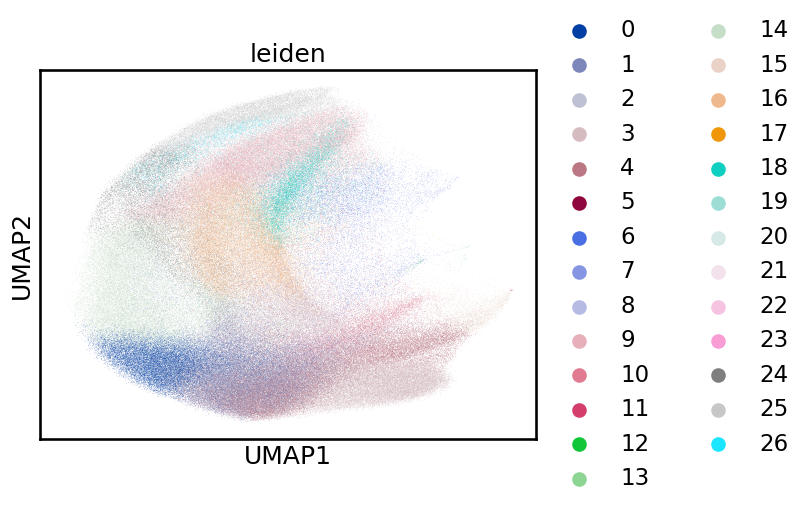

In [29]:
if GPU:
    sc.pl.umap(RP.adata, color="leiden")

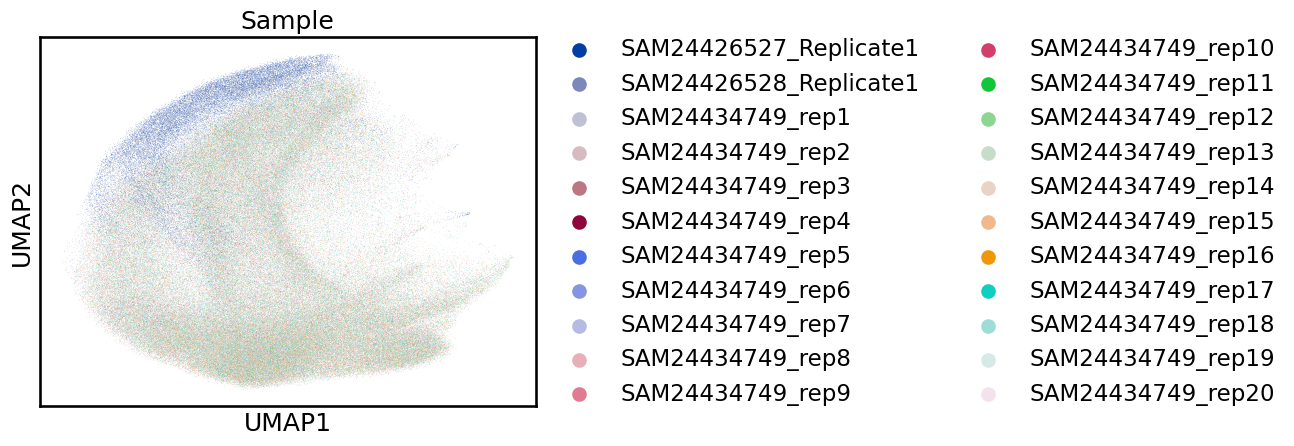

In [30]:
if GPU:
    sc.pl.umap(RP.adata, color=groupby, cmap=plt.get_cmap('viridis'))

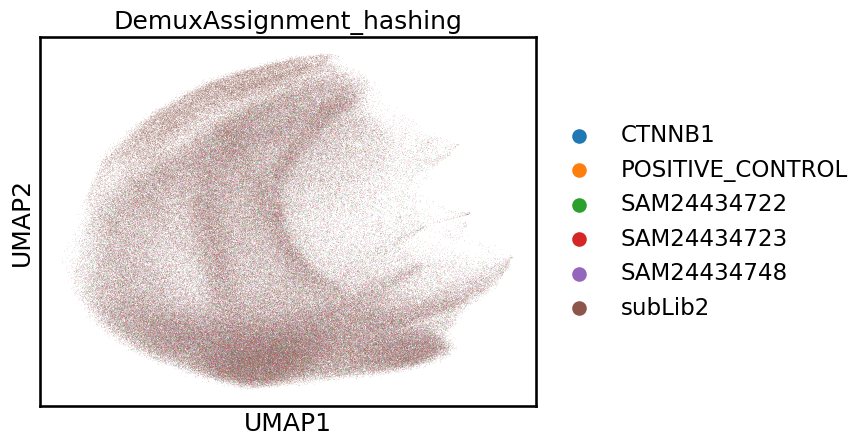

In [31]:
if GPU:
    sc.pl.umap(RP.adata, color="DemuxAssignment_hashing", cmap=plt.get_cmap('viridis'))

## Batch Correction (scVI)

In [32]:
Batch_needed = True

In [33]:
if Batch_needed:
    RP.run_scvi(counts_layer = "counts", batch_key = "DemuxAssignment_hashing")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 22/22: 100%|██████████| 22/22 [09:40<00:00, 26.43s/it, loss=245, v_num=1]

`Trainer.fit` stopped: `max_epochs=22` reached.


Epoch 22/22: 100%|██████████| 22/22 [09:40<00:00, 26.40s/it, loss=245, v_num=1]
Scvi Training took 594.0554826259613 seconds


In [34]:
if Batch_needed:
    RP.run_knn(n_neighbors=30, knn_n_pcs=30, use_rep='X_scVI')

kNN took 26.308326244354248 seconds


In [35]:
RP.run_umap(umap_min_dist= 0.3, umap_spread=1.0)

UMAP took 10.194162845611572 seconds


In [36]:
RP.run_leiden()

Leiden clustering took 1.2478857040405273 seconds


## Plot PCA UMAP after batch correction

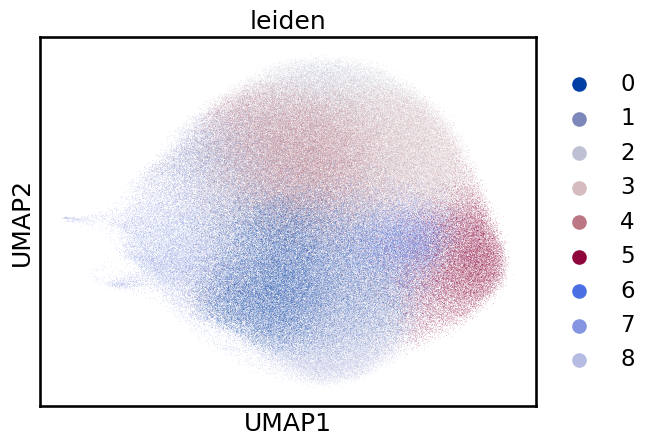

In [37]:
if Batch_needed:
    sc.pl.umap(RP.adata, color="leiden")

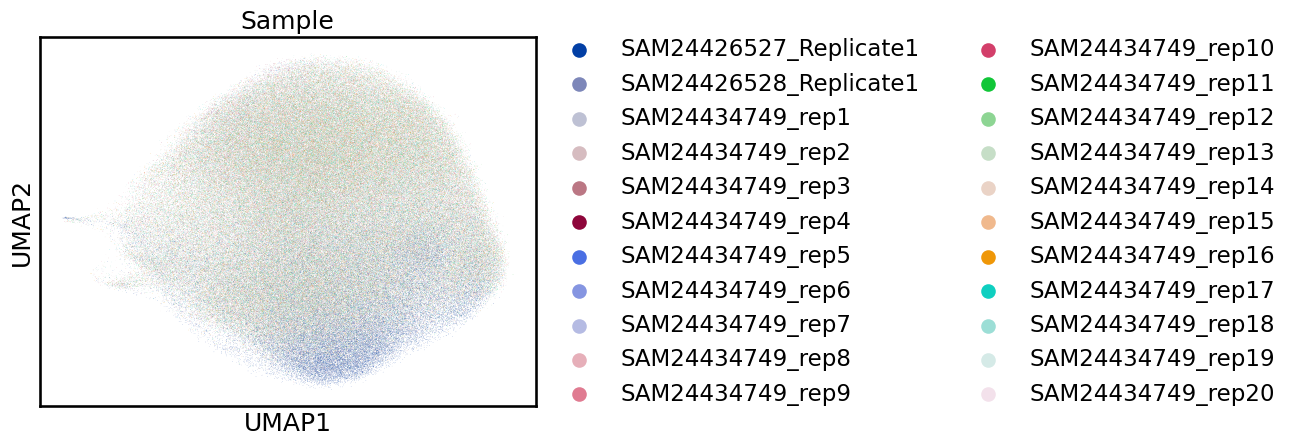

In [38]:
if Batch_needed:
    sc.pl.umap(RP.adata, color=groupby)

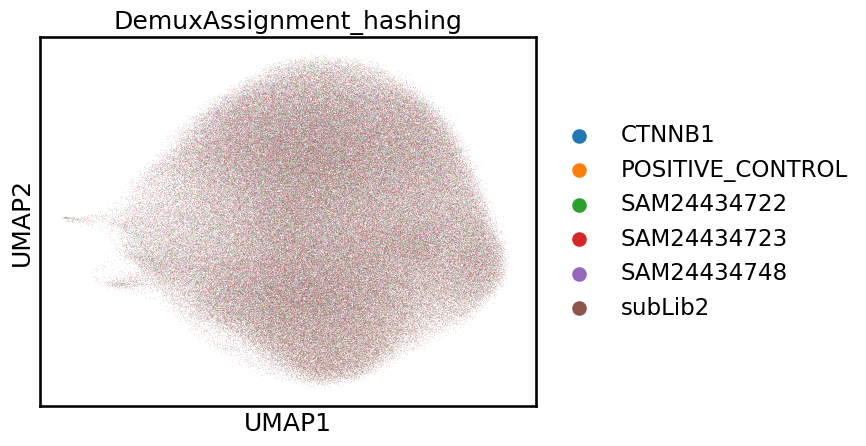

In [39]:
if Batch_needed:
    sc.pl.umap(RP.adata, color="DemuxAssignment_hashing")

## Batch Correction (harmony)

In [ ]:
if Batch_needed:
    RP.run_harmony()

In [ ]:
if Batch_needed:
    RP.run_knn(n_neighbors=30, knn_n_pcs=30, use_rep='X_harmony')

In [ ]:
RP.run_umap(umap_min_dist= 0.3, umap_spread=1.0)

In [ ]:
RP.run_leiden()

## Plot PCA UMAP after batch correction (harmony)

In [ ]:
if Batch_needed:
    sc.pl.umap(RP.adata, color="leiden")

In [ ]:
if Batch_needed:
    sc.pl.umap(RP.adata, color=groupby)

In [ ]:
if Batch_needed:
    sc.pl.umap(RP.adata, color="DemuxAssignment_hashing")

In [40]:
if GPU==False:
    adata_tmp = proc.proc(adata_tmp, 'auto', norm=True, scale=True, regress=False, embedding=True)
    sc.pl.umap(adata_tmp, color=groupby)

## Centering the embeddings at NTC

### PCA

In [44]:
proc.centered_embedding_adata(
            RP.adata,
            'X_pca',
            'gene_symbol',
      'DemuxAssignment_crispr',
            "NTC",
pool_ntcs=False)

### scVI

In [45]:
proc.centered_embedding_adata(
            RP.adata,
            'X_scVI',
            'gene_symbol',
      'DemuxAssignment_crispr',
            "NTC",
pool_ntcs=False)

### harmony

In [ ]:
proc.centered_embedding_adata(
            RP.adata,
            'X_harmony',
            'gene_symbol',
      'DemuxAssignment_crispr',
            "NTC",
pool_ntcs=False)

In [46]:
RP.adata_

AnnData object with n_obs × n_vars = 360087 × 33998
    obs: 'Sample', 'Barcode', 'DemuxType_crispr', 'DemuxAssignment_crispr', 'DemuxType_hashing', 'DemuxAssignment_hashing', 'cellline', 'timepoint', 'gene_symbol', 'class', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'S_score', 'G2M_score', 'phase', 'SCN_class', 'batch'
    var: 'ID', 'Symbol', 'Type'
    layers: 'counts'

In [47]:
RP.adata

AnnData object with n_obs × n_vars = 360087 × 2000
    obs: 'Sample', 'Barcode', 'DemuxType_crispr', 'DemuxAssignment_crispr', 'DemuxType_hashing', 'DemuxAssignment_hashing', 'cellline', 'timepoint', 'gene_symbol', 'class', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'S_score', 'G2M_score', 'phase', 'SCN_class', 'batch', 'leiden', '_scvi_batch', '_scvi_labels'
    uns: 'neighbors', 'umap', 'leiden_colors', 'Sample_colors', 'DemuxAssignment_hashing_colors', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'X_pca', 'X_umap', 'X_scVI', 'X_pca_centered', 'X_scVI_centered'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

## Write h5ad file with embedings for Energy Distance analaysis

In [49]:
RP.adata_.obsp = RP.adata.obsp.copy()
RP.adata_.obsm = RP.adata.obsm.copy()
RP.adata_.uns = RP.adata.uns.copy()

### Store log scaled  counts

In [ ]:
RP.run_normalize()

In [ ]:
RP.adata_.layers['log_norm'] = RP.adata.layers['counts']

In [52]:
RP.adata_

AnnData object with n_obs × n_vars = 360087 × 2000
    obs: 'Sample', 'Barcode', 'DemuxType_crispr', 'DemuxAssignment_crispr', 'DemuxType_hashing', 'DemuxAssignment_hashing', 'cellline', 'timepoint', 'gene_symbol', 'class', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'S_score', 'G2M_score', 'phase', 'SCN_class', 'batch', 'leiden', '_scvi_batch', '_scvi_labels'
    uns: 'neighbors', 'umap', 'leiden_colors', 'Sample_colors', 'DemuxAssignment_hashing_colors', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'X_pca', 'X_umap', 'X_scVI', 'X_pca_centered', 'X_scVI_centered'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [50]:
if GPU:
    adata_embedding = RP.adata_.copy()
else:
    adata_embedding = adata_tmp.copy()  

In [56]:
adata_embedding.write_h5ad(raw_embedding)